<a href="https://colab.research.google.com/github/Berigny/p-adic-memory/blob/main/Photonic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

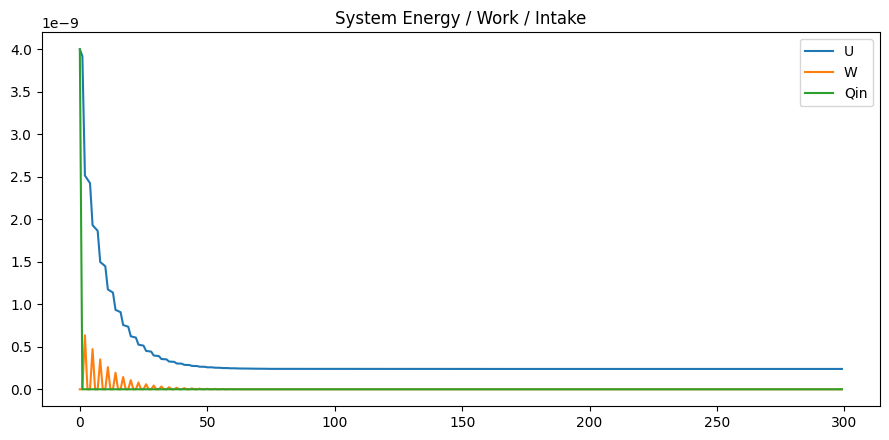

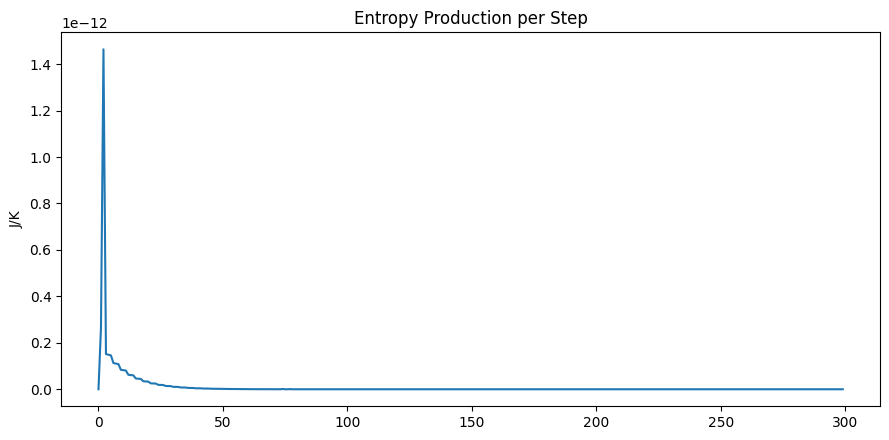

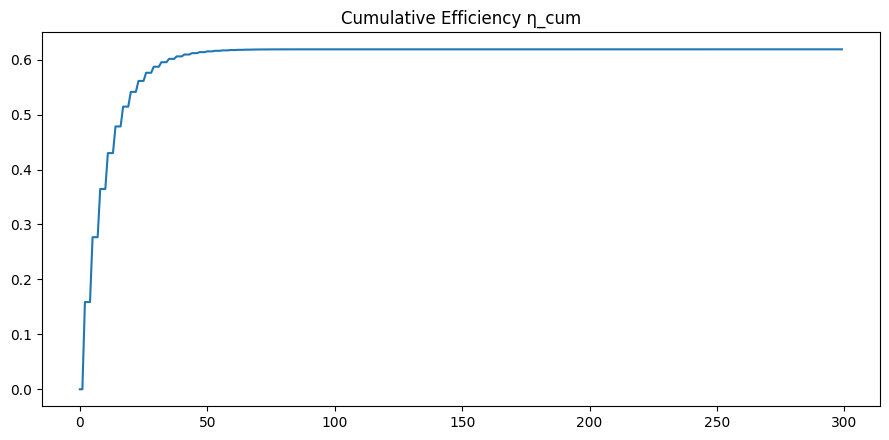

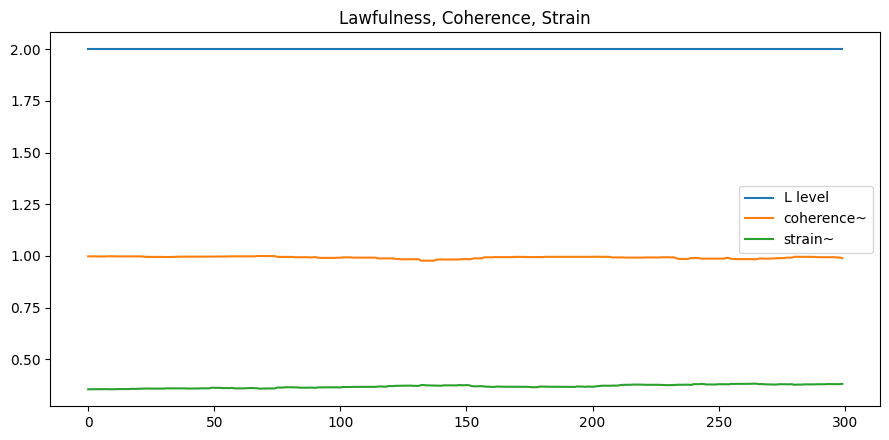

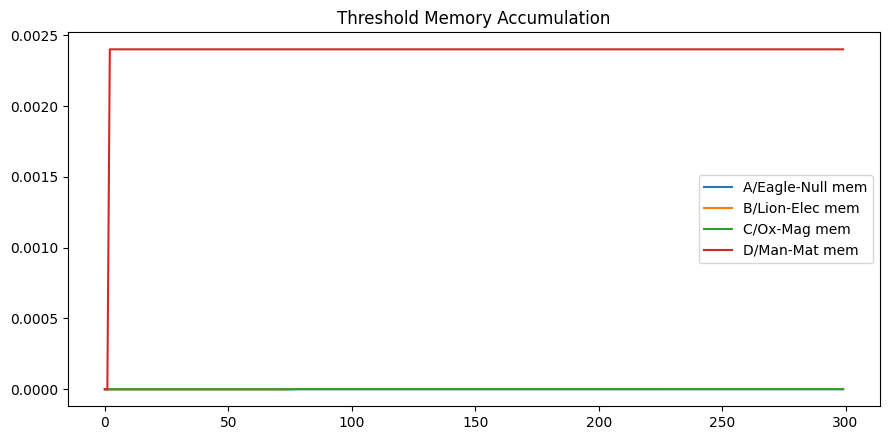

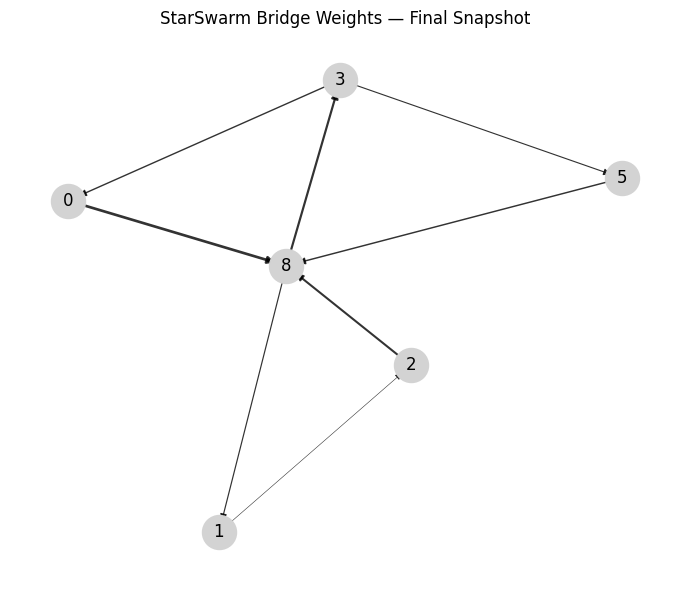

'/mnt/data/compass_photonic_starswarm_v2.csv'

In [2]:
# Modular Compass–Photonic Thermodynamic Swarm (v2)
# Spec:
# - 4 coupled chambers (S1+S2 star) with mediator gating and prime-weighted bridges
# - Base-4 lawfulness L in {0,1,2,3} with pulses (entropy/coherence driven)
# - Threshold memory model: capability unlocks when coherence & lawful cycles sustained
# - Representative (C10-style) coordinator modulates commit and coherence multiplier
# - Plots by metric + CSV export; lightweight "living map" using networkx if available
#
# Notes:
# - This is a systems-level simulator (no wave optics); it captures energy/entropy/work,
#   lawfulness gating, bridge penalties, and emergent synchrony.


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, random
import os # Import the os module

# Optional for topology snapshots
try:
    import networkx as nx
    HAS_NX = True
except Exception:
    HAS_NX = False

np.random.seed(10)
random.seed(10)

# -----------------------------
# Global parameters
# -----------------------------
STEPS = 300
T0 = 300.0
ALPHA_T = 5e-8                 # bath sensitivity
QIN_BASE = 1e-9                 # intake quantum
ETA_NOM = 0.35
K_NOM = 0.6
LEAK_FRAC = 0.02
MAINT_FRAC = 0.005
COUPLING_BASE = 0.5            # cross-heat coupling between chambers
LAW_INFLUENCE = 0.6            # how strongly lawfulness influences K/eta

# Lawfulness tables
K_L = {0:0.2, 1:0.4, 2:0.6, 3:0.8}
ETA_L = {0:0.05, 1:0.18, 2:0.35, 3:0.42}
STORE_FRAC_L = {0:0.00, 1:0.15, 2:0.25, 3:0.33}
SIGMA_PEN_L = {0:2.00, 1:1.25, 2:1.00, 3:0.85}
STRICT_THRESHOLD = 2          # core commit needs L >= 2



# Prime map for p-adic / bridge penalties
PRIMES = {0:2,1:3,2:5,3:7,5:11,7:13,11:17,13:19,8:23}

# Compass state angles (Saad mapping)
ANGLES = {0:0.0, 1:np.pi/2, 2:-np.pi/2, 3:np.pi}

# -----------------------------
# Utilities
# -----------------------------
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def compass_energy(state, theta_pref, gap):
    return 1.0 - np.cos(ANGLES[state]-theta_pref) + gap

def bridge_entropy_penalty(L_level, prime_weight):
    base = (3 - L_level) / 3.0
    return base * math.log1p(prime_weight) * 1e-12

def quantise_L(score):
    if score < 0.25: return 0
    if score < 0.5:  return 1
    if score < 0.75: return 2
    return 3

# -----------------------------
# Classes
# -----------------------------
class Chamber:
    sequence = [0,'C',1,2,'C',3,0]
    def __init__(self, name, prime, theta0=0.0, omega=2*np.pi/240.0, phase=0):
        self.name = name
        self.prime = prime
        self.theta0 = theta0 + phase
        self.omega = omega
        self.state_idx = 0
        self.mediator = 0.0
        self.store = 0.0
        self.cum_entropy = 0.0
        self.last_states = []
        self.last_angle_err = []
        self.memory = 0.0         # threshold memory score
        self.unlocked = False
        self.unlock_time = None

    def theta_pref(self, t):
        return self.theta0 + self.omega*t

    def Lscore(self):
        # Coherence: alignment with last chosen angle; Strain: sign flips in state transitions
        if len(self.last_states) < 8:
            return 0.5
        diffs = np.diff(self.last_states[-8:])
        flips = 0
        if diffs.size > 1:
            s = np.sign(diffs)
            flips = np.sum(np.abs(np.diff(s[s!=0]))>0) if np.any(s!=0) else 0
        strain = clamp(flips/6.0, 0.0, 1.0)
        align = 0.5*(1.0 + np.cos(self.last_angle_err[-1] if self.last_angle_err else 0.0))
        return clamp(0.7*align - 0.4*strain + 0.35, 0.0, 1.0)

    def step(self, t, Qin_in, L_level, rep_gate, bath_T):
        """Advance one step; rep_gate blocks commit when False; returns (heat_out, Qin, W, Sigma, token)"""
        token = Chamber.sequence[self.state_idx]
        # Effective parameters with lawfulness
        K_eff  = K_NOM   * (K_L[L_level]/K_L[2])
        eta_eff = ETA_NOM * (ETA_L[L_level]/ETA_L[2])
        store_frac = STORE_FRAC_L[L_level]
        Sigma_step = 0.0
        Qin = 0.0
        W = 0.0
        heat_for_coupling = 0.0

        # Passive leak
        if self.mediator > 0:
            leak = LEAK_FRAC * self.mediator
            self.mediator -= leak
            Sigma_step += leak / bath_T

        # Gated transitions
        if token == 0 and Chamber.sequence[(self.state_idx+1)%len(Chamber.sequence)] == 'C':
            Qin = QIN_BASE + Qin_in
            self.mediator += Qin
            self.state_idx = (self.state_idx+1) % len(Chamber.sequence)

        elif token == 'C':
            # choose between 1 and 3 by energy projection
            cand = [1,3]
            gap_commit = 0.5 if (L_level < STRICT_THRESHOLD or not rep_gate) else 0.0
            energies = {s: compass_energy(s, self.theta_pref(t), gap_commit if s==3 else 0.0) for s in cand}
            choice = min(cand, key=lambda s: energies[s])
            self.state_idx = Chamber.sequence.index(choice)

        elif token == 1:
            available = self.mediator
            W = K_eff * eta_eff * available
            self.mediator -= W
            self.state_idx = (self.state_idx+1) % len(Chamber.sequence)

        elif token == 2:
            self.state_idx = (self.state_idx+1) % len(Chamber.sequence)

        elif token == 3:
            # Commit if allowed
            if L_level >= STRICT_THRESHOLD and rep_gate:
                commit = store_frac * self.mediator
                self.mediator -= commit
                self.store += commit
                # Memory: only grows when lawful commits happen consecutively
                self.memory += 0.01 * commit / (QIN_BASE+1e-18)
            else:
                stall = 0.1 * self.mediator
                self.mediator -= stall
                Sigma_step += stall / bath_T
            # Heat dump
            residual = self.mediator
            self.mediator = 0.0
            maintenance = MAINT_FRAC * self.store
            self.store -= maintenance
            heat = residual + maintenance
            heat_for_coupling = COUPLING_BASE * heat
            Sigma_step += (1.0 - COUPLING_BASE) * heat / bath_T
            self.state_idx = (self.state_idx+1) % len(Chamber.sequence)

        # Angle bookkeeping
        token_now = Chamber.sequence[self.state_idx]
        if token_now in [0,1,2,3]:
            angle_err = ANGLES[token_now] - self.theta_pref(t)
        else:
            angle_err = 0.0
        self.last_states.append(0 if token_now=='C' else token_now)
        self.last_angle_err.append(angle_err)

        # Unlock logic (threshold memory)
        if (not self.unlocked) and (self.memory > 0.6) and (L_level >= 2):
            self.unlocked = True
            self.unlock_time = t

        return heat_for_coupling, Qin, W, Sigma_step, token_now

class Representative:
    """C10-style coordinator; computes global lawfulness/coherence and gates commits when strain high."""
    def __init__(self):
        self.history_coh = []
        self.history_strain = []
        self.history_Lscore = []

    def compute_graph_metrics(self, edge_w):
        # Coherence: low out-variance -> high cohesion
        variances = []
        for u in sorted({u for (u,_) in edge_w}):
            outs = [edge_w[(u,v)] for (uu,v) in edge_w if uu==u]
            if len(outs) > 1:
                mu = np.mean(outs)
                variances.append(np.mean((np.array(outs)-mu)**2))
        coh = 1.0 / (1.0 + (np.mean(variances) if variances else 1.0))
        # Strain: sparsity (L2/L1)
        mags = np.array(list(edge_w.values()))
        l1 = np.sum(np.abs(mags)); l2 = np.sqrt(np.sum(mags**2))+1e-12
        strain = clamp(l2/(l1+1e-12), 0.0, 1.0)
        # Adelic proxy
        prod = 1.0
        for (u,v), w in random.sample(list(edge_w.items()), min(10, len(edge_w))):
            p = PRIMES.get(u, 3)
            prod *= clamp(w, 0.05, 0.95)**(1.0/p)
        adelic_dev = abs(np.log(prod+1e-12))
        adelic = 1.0/(1.0+adelic_dev)
        Lscore = clamp(0.6*coh + 0.4*adelic - 0.5*strain, 0.0, 1.0)

        self.history_coh.append(coh)
        self.history_strain.append(strain)
        self.history_Lscore.append(Lscore)
        return Lscore, coh, strain

    def gate_commit(self, coh, strain, L_level):
        # Strict when strain high or L low; reward synchrony with K boost downstream
        rep_gate = (L_level >= 2) and (strain < 0.5)
        K_sync = 1.0 + 0.1 * (coh - 0.5)  # modest boost
        return rep_gate, clamp(K_sync, 0.8, 1.2)

class StarSwarm:
    """Four-chamber star with centroided bridge graph and prime-weighted penalties."""
    def __init__(self):
        # chambers: A,B,C,D mapped to nodes 0,1,2,3 for simplicity
        self.ch = [
            Chamber("A/Eagle-Null", prime=2,  theta0=0.0, phase=0.0),
            Chamber("B/Lion-Elec", prime=3,   theta0=0.2, phase=0.3),
            Chamber("C/Ox-Mag",   prime=5,   theta0=-0.2, phase=0.6),
            Chamber("D/Man-Mat",  prime=7,   theta0=np.pi, phase=0.9),
        ]
        # Directed edges (subset) including centroid (8) conceptually
        self.edges = {
            0:[8], 8:[1,3], 1:[2], 2:[8], 3:[0,5], 5:[8]
        }
        # Weights initialised unseeded around 0.5
        self.edge_w = {}
        for u, outs in self.edges.items():
            for v in outs:
                self.edge_w[(u,v)] = 0.5 + 0.05*np.random.randn()
        self.rep = Representative()
        # logs
        self.logs = []

    def step(self, t, heat_in=None):
        if heat_in is None: heat_in = [0.0]*4
        # Representative computes global metrics from current bridge weights
        Lscore, coh, strain = self.rep.compute_graph_metrics(self.edge_w)
        L_level = quantise_L(Lscore)
        rep_gate, K_sync = self.rep.gate_commit(coh, strain, L_level)

        # Bath temp
        bath_T = T0 + ALPHA_T * sum([c.cum_entropy for c in self.ch])

        # Advance chambers; pass coupling heat in pairwise ring A->B->C->D->A
        order = [0,1,2,3]
        heat_out = [0.0]*4
        Qin_step = 0.0; W_step = 0.0; Sigma_step = 0.0
        tokens = []

        for idx in order:
            prev_idx = (idx-1)%4
            h_in = heat_out[prev_idx]  # previous chamber's just-produced heat
            # Apply prime-weighted bridge penalty to incoming heat (simulate loss/entropy)
            p = self.ch[idx].prime
            penalty = bridge_entropy_penalty(L_level, p) * (self.edge_w.get((3,5),0.5)**2)
            # Only affect entropy, not Qin magnitude (thermo realism-lite)
            self.ch[idx].cum_entropy += penalty
            # Effective K with synchrony multiplier
            heat, Qin, W, Sigma, tok = self.ch[idx].step(t, Qin_in=h_in, L_level=L_level, rep_gate=rep_gate, bath_T=bath_T)
            # Apply K_sync to work (post-hoc coordination gain)
            W *= K_sync
            # Accumulate
            heat_out[idx] = heat
            Qin_step += Qin; W_step += W; Sigma_step += Sigma
            tokens.append(tok)

        # Evolution of edge weights: reward efficiency and coherence, penalise strain
        reward = clamp(0.6*(W_step/(Qin_step+1e-18)) + 0.3*coh - 0.3*strain - 0.1*np.tanh(Sigma_step*1e9), 0.0, 1.0)
        for k in list(self.edge_w.keys()):
            if random.random() < 0.12:
                delta = 0.06 * np.tanh((reward-0.5)*2.0) * np.random.randn()
                self.edge_w[k] = clamp(self.edge_w[k] + delta, 0.02, 1.5)

        # Lawfulness pulse logic (global): if entropy low and coherence high for several steps, bump L_score slightly
        if len(self.rep.history_Lscore) >= 12:
            recent_S = np.mean([self.ch[i].cum_entropy for i in range(4)]) - np.mean([self.ch[i].cum_entropy for i in range(4)])
        # log
        self.logs.append((t, L_level, float(Qin_step), float(W_step), float(Sigma_step), float(coh), float(strain), tokens))
        return L_level, Qin_step, W_step, Sigma_step, coh, strain, tokens, heat_out

# -----------------------------
# Run simulation
# -----------------------------
swarm = StarSwarm()

U_hist=[]; Qin_hist=[]; W_hist=[]; Sigma_hist=[]; L_hist=[]; coh_hist=[]; strain_hist=[]
eta_hist=[]; T_hist=[]; tokens_hist=[]
mem_hist=[[],[],[],[]]; unlock_times=[None]*4

for t in range(STEPS):
    L_level, Qin_t, W_t, Sigma_t, coh_t, strain_t, tokens, heat_out = swarm.step(t)
    # System metrics
    U_t = sum([c.mediator + c.store for c in swarm.ch])
    T_env = T0 + ALPHA_T * sum([c.cum_entropy for c in swarm.ch])
    eta_t = (W_t/(Qin_t+1e-18)) if Qin_t>0 else 0.0

    U_hist.append(U_t); Qin_hist.append(Qin_t); W_hist.append(W_t); Sigma_hist.append(Sigma_t)
    L_hist.append(L_level); coh_hist.append(coh_t); strain_hist.append(strain_t); eta_hist.append(eta_t); T_hist.append(T_env)
    tokens_hist.append(tokens)
    for i,c in enumerate(swarm.ch):
        mem_hist[i].append(c.memory)
        if c.unlocked and unlock_times[i] is None:
            unlock_times[i]=t

# Cumulative efficiency
cum_Qin = np.cumsum(Qin_hist); cum_W = np.cumsum(W_hist); eta_cum = np.divide(cum_W, np.maximum(cum_Qin,1e-18))

# -----------------------------
# Plots
# -----------------------------
plt.figure(figsize=(9,4.5));
plt.plot(U_hist,label="U"); plt.plot(W_hist,label="W"); plt.plot(Qin_hist,label="Qin");
plt.title("System Energy / Work / Intake"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4.5));
plt.plot(Sigma_hist); plt.title("Entropy Production per Step"); plt.ylabel("J/K"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4.5));
plt.plot(eta_cum); plt.title("Cumulative Efficiency η_cum"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4.5));
plt.step(range(STEPS), L_hist, where='post', label="L level");
plt.plot(coh_hist, label="coherence~"); plt.plot(strain_hist, label="strain~");
plt.title("Lawfulness, Coherence, Strain"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4.5));
for i in range(4): plt.plot(mem_hist[i], label=f"{swarm.ch[i].name} mem")
plt.title("Threshold Memory Accumulation"); plt.legend(); plt.tight_layout(); plt.show()

# Living map snapshot if networkx is available
if HAS_NX:
    G = nx.DiGraph()
    for (u,v),w in swarm.edge_w.items():
        G.add_edge(u,v, weight=w)
    pos = nx.spring_layout(G, seed=7, k=0.9, iterations=200)
    fig, ax = plt.subplots(figsize=(7,6))
    widths = [clamp(G[u][v]['weight'],0.05,1.5)*2.5 for u,v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=600, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, width=widths, arrows=True, arrowstyle='-|>', ax=ax, alpha=0.8)
    ax.set_title("StarSwarm Bridge Weights — Final Snapshot")
    ax.axis('off'); plt.tight_layout(); plt.show()

# -----------------------------
# Export CSV
# -----------------------------
# Create the directory if it doesn't exist
csv_dir = "/mnt/data"
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)

df = pd.DataFrame({
    "step": np.arange(STEPS),
    "U": U_hist, "Qin": Qin_hist, "W": W_hist, "Sigma": Sigma_hist,
    "eta_cum": eta_cum, "Llevel": L_hist, "coherence": coh_hist, "strain": strain_hist, "T_env": T_hist
})
for i in range(4):
    df[f"mem_{i}"] = mem_hist[i]
csv_path = os.path.join(csv_dir, "compass_photonic_starswarm_v2.csv") # Use os.path.join for better path handling
df.to_csv(csv_path, index=False)

csv_path